<a href="https://colab.research.google.com/github/sumankmaiti/All-in-one/blob/main/Noise_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install torch==1.7.1 torchvision==0.8.2 

     |████████████████████████████████| 776.8 MB 16 kB/s 
     |████████████████████████████████| 12.8 MB 23 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu111
    Uninstalling torch-1.9.0+cu111:
      Successfully uninstalled torch-1.9.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu111
    Uninstalling torchvision-0.10.0+cu111:
      Successfully uninstalled torchvision-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.7.1 which is incompatible.


In [ ]:
%cd /content/drive/MyDrive/Reverse_Engineering_GMs-main

/content/drive/.shortcut-targets-by-id/1IK7fVL2OoM1N5I0e6J5_TR0jmsWEL9LT/Reverse_Engineering_GMs-main


In [ ]:
from torchvision import datasets, models, transforms
import os
import torch
from torch.autograd import Variable
from skimage import io
from scipy import fftpack
import numpy as np
from torch import nn
import datetime
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from sklearn import metrics
import argparse
import PIL

In [ ]:
def roll_n(X, axis, n):
    f_idx = tuple(slice(None, None, None) if i != axis else slice(0,n,None) 
                  for i in range(X.dim()))
    b_idx = tuple(slice(None, None, None) if i != axis else slice(n,None,None)
                  for i in range(X.dim()))
    #print(axis,n,f_idx,b_idx)
    front = X[f_idx]
    back = X[b_idx]
    return torch.cat([back, front],axis)

In [ ]:
def fftshift(real, imag):
    for dim in range(1, len(real.size())):
        real = roll_n(real, axis=dim, n=real.size(dim)//2)
        imag = roll_n(imag, axis=dim, n=imag.size(dim)//2)
    return real, imag

In [ ]:
class DnCNN(nn.Module):
    def __init__(self, num_layers=17, num_features=64):
        super(DnCNN, self).__init__()
        layers = [nn.Sequential(nn.Conv2d(3, num_features, kernel_size=3, stride=1, padding=1),
                                nn.ReLU(inplace=True))]
        for i in range(num_layers - 2):
            layers.append(nn.Sequential(nn.Conv2d(num_features, num_features, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(num_features),
                                        nn.ReLU(inplace=True)))
        layers.append(nn.Conv2d(num_features, 3, kernel_size=3, padding=1))
        self.layers = nn.Sequential(*layers)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, inputs):
        y = inputs
        residual = self.layers(y)
        residual_1 = residual.clone()
        
        residual_gray=0.299*residual_1[:,0,:,:].clone()+0.587*residual_1[:,1,:,:].clone()+0.114*residual_1[:,2,:,:].clone()
        
        thirdPart_fft_1=torch.rfft(residual_gray, signal_ndim=2, onesided=False)
        
        thirdPart_fft_1_orig=thirdPart_fft_1.clone()
        
        thirdPart_fft_1[:,:,:,0],thirdPart_fft_1[:,:,:,1]=fftshift(thirdPart_fft_1[:,:,:,0],thirdPart_fft_1[:,:,:,1])
        thirdPart_fft_1=torch.sqrt(thirdPart_fft_1[:,:,:,0]**2+thirdPart_fft_1[:,:,:,1]**2)
        n=25
        (_,w,h)=thirdPart_fft_1.shape
        half_w, half_h = int(w/2), int(h/2)
        thirdPart_fft_2=thirdPart_fft_1[:,half_w-n:half_w+n+1,half_h-n:half_h+n+1].clone()
        thirdPart_fft_3=thirdPart_fft_1.clone()
        thirdPart_fft_3[:,half_w-n:half_w+n+1,half_h-n:half_h+n+1]=0
        max_value=torch.max(thirdPart_fft_3)
        thirdPart_fft_4=thirdPart_fft_1.clone()
        thirdPart_fft_4=torch.transpose(thirdPart_fft_4,1,2)
        return thirdPart_fft_1,thirdPart_fft_2, max_value, thirdPart_fft_1_orig,residual, thirdPart_fft_4, residual_gray


In [ ]:
transform_train = transforms.Compose([
transforms.Resize((128,128)),
transforms.ToTensor(),
# transforms.Normalize((0.6490, 0.6490, 0.6490), (0.1269, 0.1269, 0.1269))
])

In [ ]:
# x = x.reshape(1, 224, 224, 3)
# x = x.astype(int)
test_set=datasets.ImageFolder("/content/drive/MyDrive/Reverse_Engineering_GMs-main/test", transform_train)

In [ ]:
print(test_set[0][0].shape)
x = test_set[0][0]
x = x.detach().numpy()
x.shape

torch.Size([3, 128, 128])


(3, 128, 128)

In [ ]:
# move the image axis
from numpy import moveaxis
from numpy import asarray
from PIL import Image
data = moveaxis(x, 0, 2)
data.shape

(128, 128, 3)

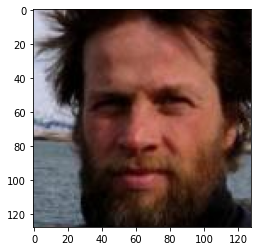

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(data)

In [ ]:
# for batch_idx_test, (inputs_test,labels_test) in enumerate(test_loader):
  # inputs_test.shape
x.shape
x=np.expand_dims(x, axis=0)
x = torch.tensor(x)
print(x.shape)

torch.Size([1, 3, 128, 128])


In [ ]:
# load the states of the trained model
model=DnCNN()
  
model_params = list(model.parameters())    
optimizer = torch.optim.Adam(model_params, lr=0.0001)

state1 = torch.load('/content/drive/MyDrive/Reverse_Engineering_GMs-main/pre_trained_models/image_attribution/celeba/0_model_27_384000.pickle', map_location=torch.device('cpu'))
optimizer.load_state_dict(state1['optimizer_1'])
model.load_state_dict(state1['state_dict_cnn'])

model.eval()

In [ ]:
with torch.no_grad():
  y,low_freq_part,max_value ,y_orig,residual, y_trans, residual_gray =model(x.type(torch.FloatTensor))

In [ ]:
z = y.reshape(128, 128)
z = z.detach().numpy()
z

array([[ 7.315233 ,  6.072665 ,  2.047637 , ...,  2.8803778,  2.047637 ,
         6.072665 ],
       [ 4.492034 , 13.30848  , 13.965394 , ...,  7.011602 ,  6.446492 ,
         2.4860828],
       [ 4.574602 ,  3.8957431, 10.487031 , ...,  1.7756865,  1.3974416,
         6.7044826],
       ...,
       [ 7.199917 ,  4.501744 ,  2.6872914, ...,  5.8997416,  8.095024 ,
         7.1865015],
       [ 4.5746026,  6.7044826,  1.3974416, ...,  8.252021 , 10.487031 ,
         3.8957431],
       [ 4.4920344,  2.4860828,  6.446492 , ..., 12.915678 , 13.965394 ,
        13.30848  ]], dtype=float32)

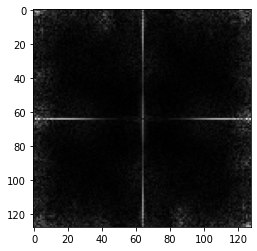

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(z, cmap="gray")

In [ ]:
z = low_freq_part.reshape(51, 51)
z = z.detach().numpy()
z

array([[59.732655, 77.86124 , 64.6721  , ..., 85.819214, 63.12897 ,
        70.88235 ],
       [34.03021 , 42.1135  , 86.978745, ..., 58.069027, 88.160614,
        52.154537],
       [32.60493 , 87.42125 , 70.413086, ..., 42.608982, 41.56911 ,
        78.604004],
       ...,
       [78.604004, 41.56911 , 42.608982, ..., 70.413086, 87.42125 ,
        32.60493 ],
       [52.154537, 88.160614, 58.069027, ..., 86.978745, 42.1135  ,
        34.03021 ],
       [70.88235 , 63.12897 , 85.819214, ..., 64.6721  , 77.86124 ,
        59.732655]], dtype=float32)

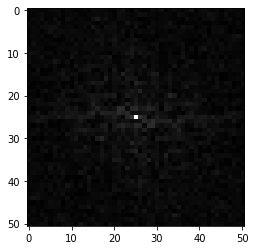

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(z, cmap="gray")

In [ ]:
max_value

tensor(223.5167, grad_fn=<MaxBackward1>)

In [ ]:
# noise generated from model
residual.shape
res = residual.detach().numpy()
res = res.reshape(3, 128, 128)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


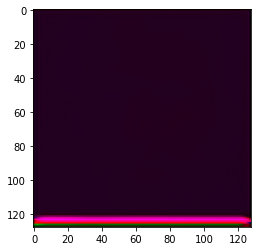

In [ ]:
for idx in range(residual.size(0)):
  input = residual[idx]
  input = input.permute(1, 2, 0)
  plt.figure()
  plt.imshow(input.numpy())
  plt.show()

In [ ]:
# CHW to HWC
z = moveaxis(res, 0, 2)
# z = z.detach().numpy()
z.shape

(128, 128, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


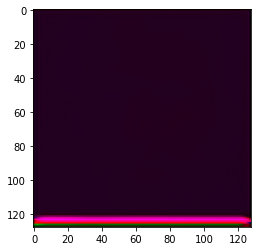

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(z)

In [ ]:
z = y_trans.reshape(128, 128)
z = z.detach().numpy()
z.shape

(128, 128)

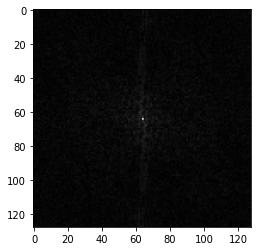

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(z, cmap="gray")

In [ ]:
x = test_set[0][0].reshape(128, 128, 3)
x = x.detach().numpy()
x.shape

(128, 128, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


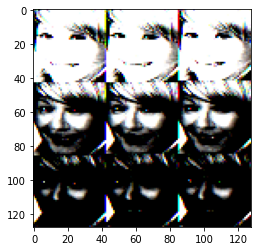

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(x, cmap="gray")

In [ ]:
z = residual_gray.reshape(128,128)
z = z.detach().numpy()
z.shape

(128, 128)

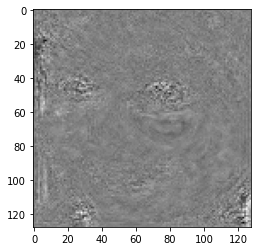

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(z, cmap="gray")